In [16]:
import os,sys,re
import pandas as pd
import numpy as np
from importlib import reload
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

from src import PATH, utils,my_metrics
from src import leukocyte_cluster as LEUC

# read data and supplement info

In [6]:
## this is path 2 ..
ALL = utils.read_leukocyte(PATH.leukocyte_path)

# preprocessing
DF_filtered, statistics=LEUC.statistics_preprocess(ALL,False)
print(DF_filtered.shape)
DF_filtered.head(1)

(3136, 21)


,id,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,NK cells activated,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Neutrophils
0,TCGA-05-4249-01A-01R-1107-07,0.002131,0.023685,0.079791,0.030423,0.097957,0.0,0.034192,0.029121,0.0,...,0.006224,0.010681,0.009018,0.038816,0.116087,0.351658,0.007345,0.139602,0.0,0.023269


take data and its cell label

In [36]:
print(DF_filtered.iloc[:,1:].columns)
data = DF_filtered.iloc[:,1:].values
data = np.divide(data,data.sum(axis=1).reshape(-1,1))

cell_columns=DF_filtered.iloc[:,1:].columns
colors = utils.read_color()         # read leukocyte color
color_ls=colors.loc[cell_columns].HEX.values   # select from all
# ALL_tsnes = LEUC.t_sne_tuning(data,'ALL.npy')
data.shape

Index(['B cells naive', 'B cells memory', 'Plasma cells', 'T cells CD8',
       'T cells CD4 memory resting', 'T cells CD4 memory activated',
       'T cells follicular helper', 'T cells regulatory (Tregs)',
       'T cells gamma delta', 'NK cells resting', 'NK cells activated',
       'Monocytes', 'Macrophages M0', 'Macrophages M1', 'Macrophages M2',
       'Dendritic cells resting', 'Dendritic cells activated',
       'Mast cells resting', 'Mast cells activated', 'Neutrophils'],
      dtype='object')


(3136, 20)

# Clustering 

In [37]:
r_labels,r_metrics_dict = LEUC.cluster3(data,n_clusters=range(2,11))

**select cluster number by <font size=5 color='darkred'>elbow method</font>**
 
   - Indicative values are % of explained variance, defined as 
   
      `Between-group-variance / total-variance`
   
   - And its python implement is 
   ```python
    my_metrics.explain_variance(data,label,define_by='B_2_T')
   ```
   

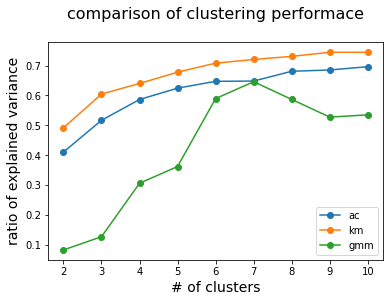

In [38]:
for method in ['ac','km','gmm']:
    r_pctg_exp_vars = [my_metrics.explain_variance(data,label) for label in r_labels[method]]
    plt.plot(range(2,11),r_pctg_exp_vars,'-o',label=method)
plt.xlabel("# of clusters",fontsize=14);
plt.ylabel("ratio of explained variance",fontsize=14);
plt.title("comparison of clustering performace\n",fontsize=16);
plt.legend();

<font size=4><font color='orange'>**K-Means</font> performs the best among all the methods**
      
Zoom in to kMeans method 

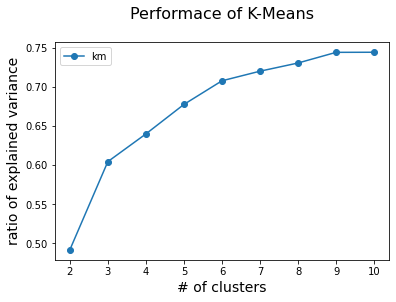

In [39]:
r_pctg_exp_vars = [my_metrics.explain_variance(data,label) for label in r_labels['km']]

plt.plot(range(2,11),r_pctg_exp_vars,'-o',label='km');
plt.xlabel("# of clusters",fontsize=14)
plt.ylabel("ratio of explained variance",fontsize=14);
plt.title("Performace of K-Means\n",fontsize=16);
plt.legend();

<font size=5 color='navy'> According to elbow method , 3 group and 6 group should be picked

In [104]:
km_label = pd.read_csv(PATH.data_path+"/label/20210310_recluster_stage_info.csv")

km3=km_label.km3.values
km6=km_label.km6.values

n500_md036 = km_label[['umap_axis0','umap_axis1']].values

# Umap scatter

In [59]:
ummap = umap.UMAP(n_neighbors=500,min_dist=0.46,n_jobs=8,force_approximation_algorithm=True)
%time ummap.fit(data)

CPU times: user 2min 32s, sys: 2.43 s, total: 2min 35s
Wall time: 27.1 s


UMAP(dens_frac=0.0, dens_lambda=0.0, force_approximation_algorithm=True,
     min_dist=0.46, n_jobs=8, n_neighbors=500)

In [93]:
def plot_group_scatter(um_embedding,r_labels=None,method=None,vote=None,direct_label=None):
    
    if r_labels is not None:
        # give in labels_dict and vote
        n_vote = len(vote)
        fig,axs = plt.subplots(1,n_vote,figsize=(7*n_vote,5))
        
        for i in range(n_vote):
            axs[i].scatter(um_embedding[:,0],um_embedding[:,1],s=5,c=r_labels[method][vote[i]]);
            axs[i].set_title("%d group"%len(np.unique(r_labels[method][vote[i]])),fontsize=14)
            
    elif direct_label is not None:
        # assign label directly 
        fig=plt.figure(figsize=(10,7))
        ax = fig.gca()
        ax.scatter(um_embedding[:,0],um_embedding[:,1],s=10,c=direct_label);
#         ax.set_title("%d group"%len(np.unique(direct_label)),fontsize=14)
#         ax.set_xticks([])
#         ax.set_yticks([])
        ax.set_xlabel("UMAP-1",fontsize=15)
        ax.set_ylabel("UMAP-2",fontsize=15)

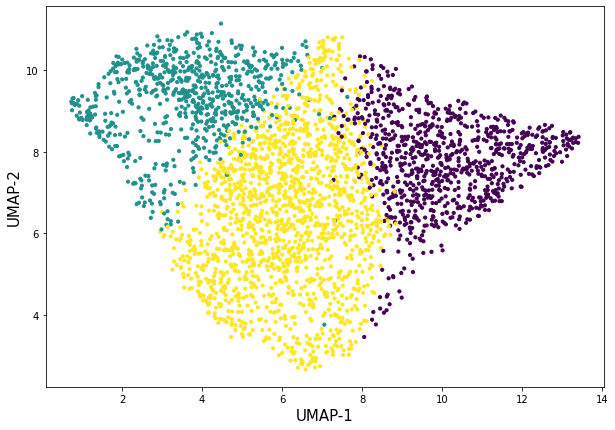

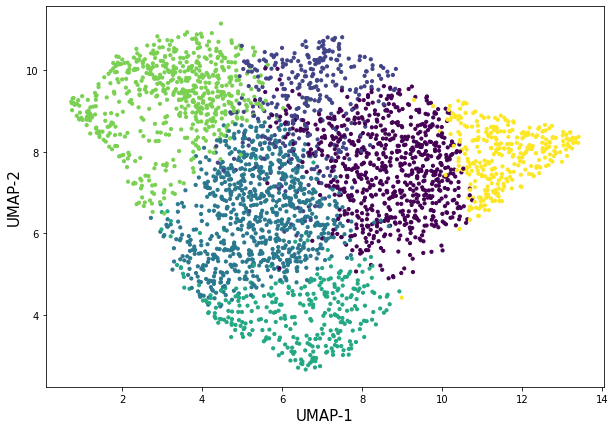

In [94]:
# local_connectivity=5.0
n500_md036=ummap.embedding_
# ploting
rec_umap_pdf = PdfPages("report/20210310_Umap_scatterplot.pdf")
plot_group_scatter(n500_md036,direct_label=km3)
rec_umap_pdf.savefig()
plot_group_scatter(n500_md036,direct_label=km6)
rec_umap_pdf.savefig()
rec_umap_pdf.close()

# stack bar plot to show compositional difference of white cell

In [50]:
rec_stbar_pdf = PdfPages("report/20210310_recluster_stack_barplot.pdf")

this will take several minutes


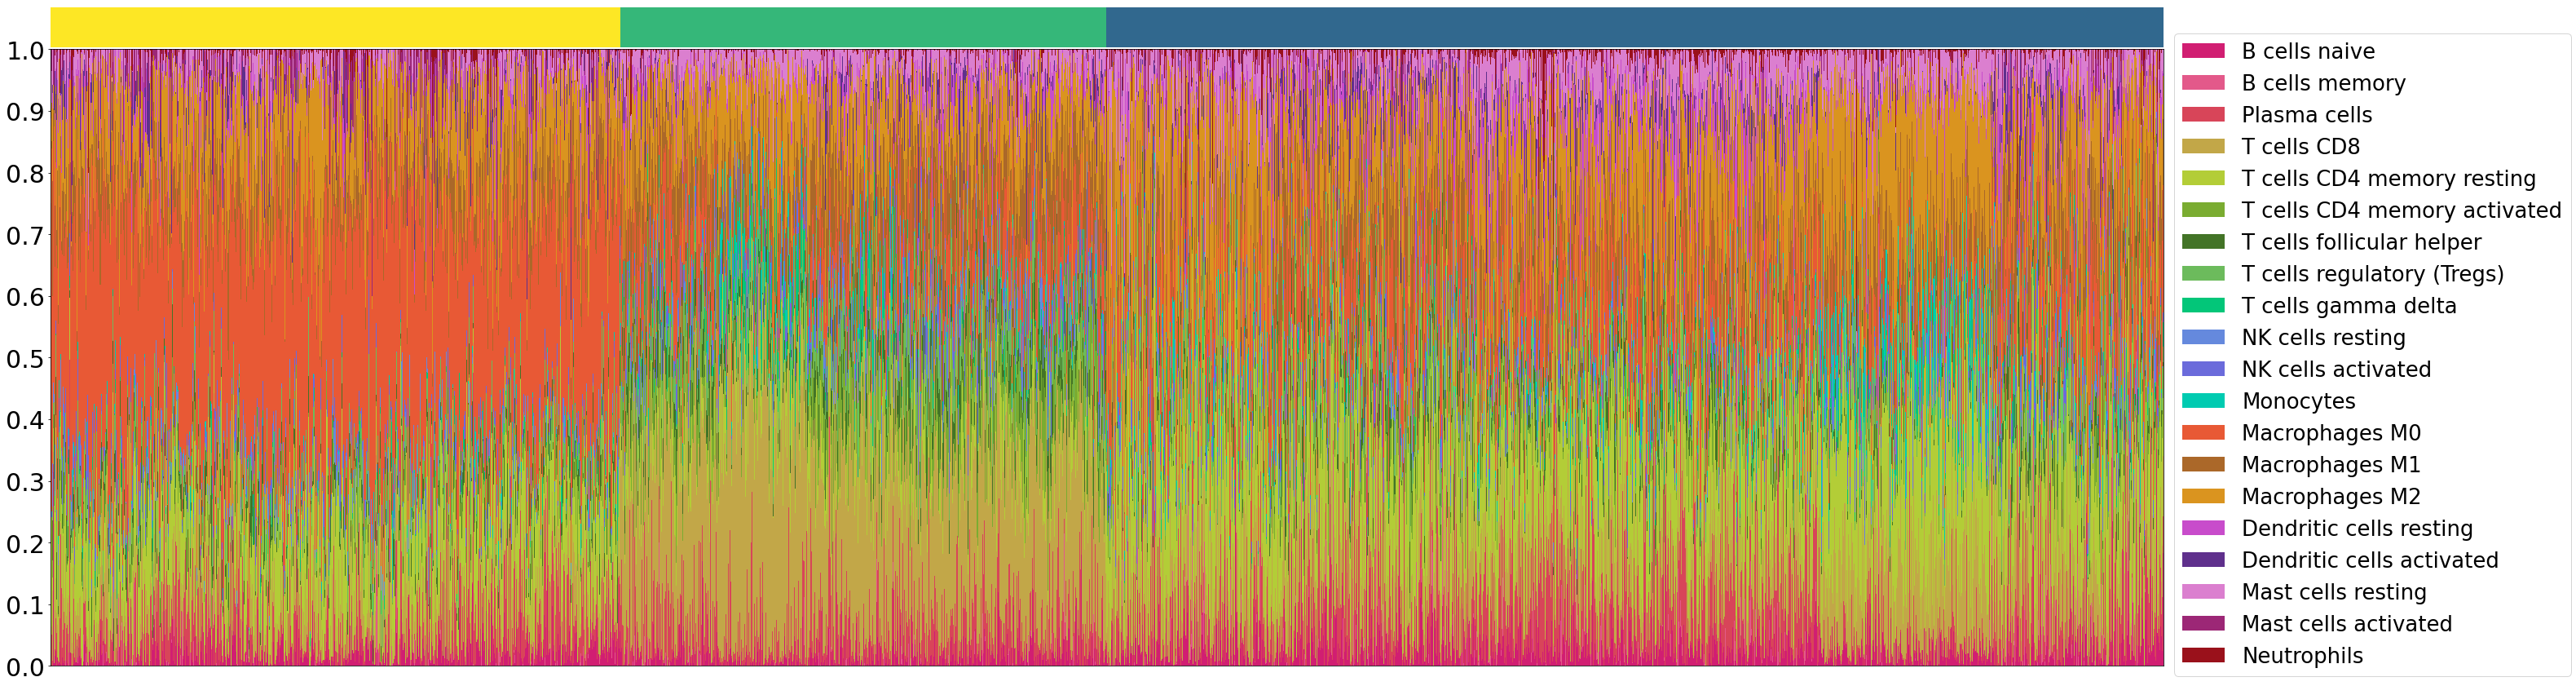

In [51]:
sorted_data,label,_ = LEUC.sort_data_by_label(data,None,None,direct_label=km3)
g3_stbar = LEUC.stack_barplot(sorted_data,label,cell_columns,cmap=color_ls)
rec_stbar_pdf.savefig()

this will take several minutes


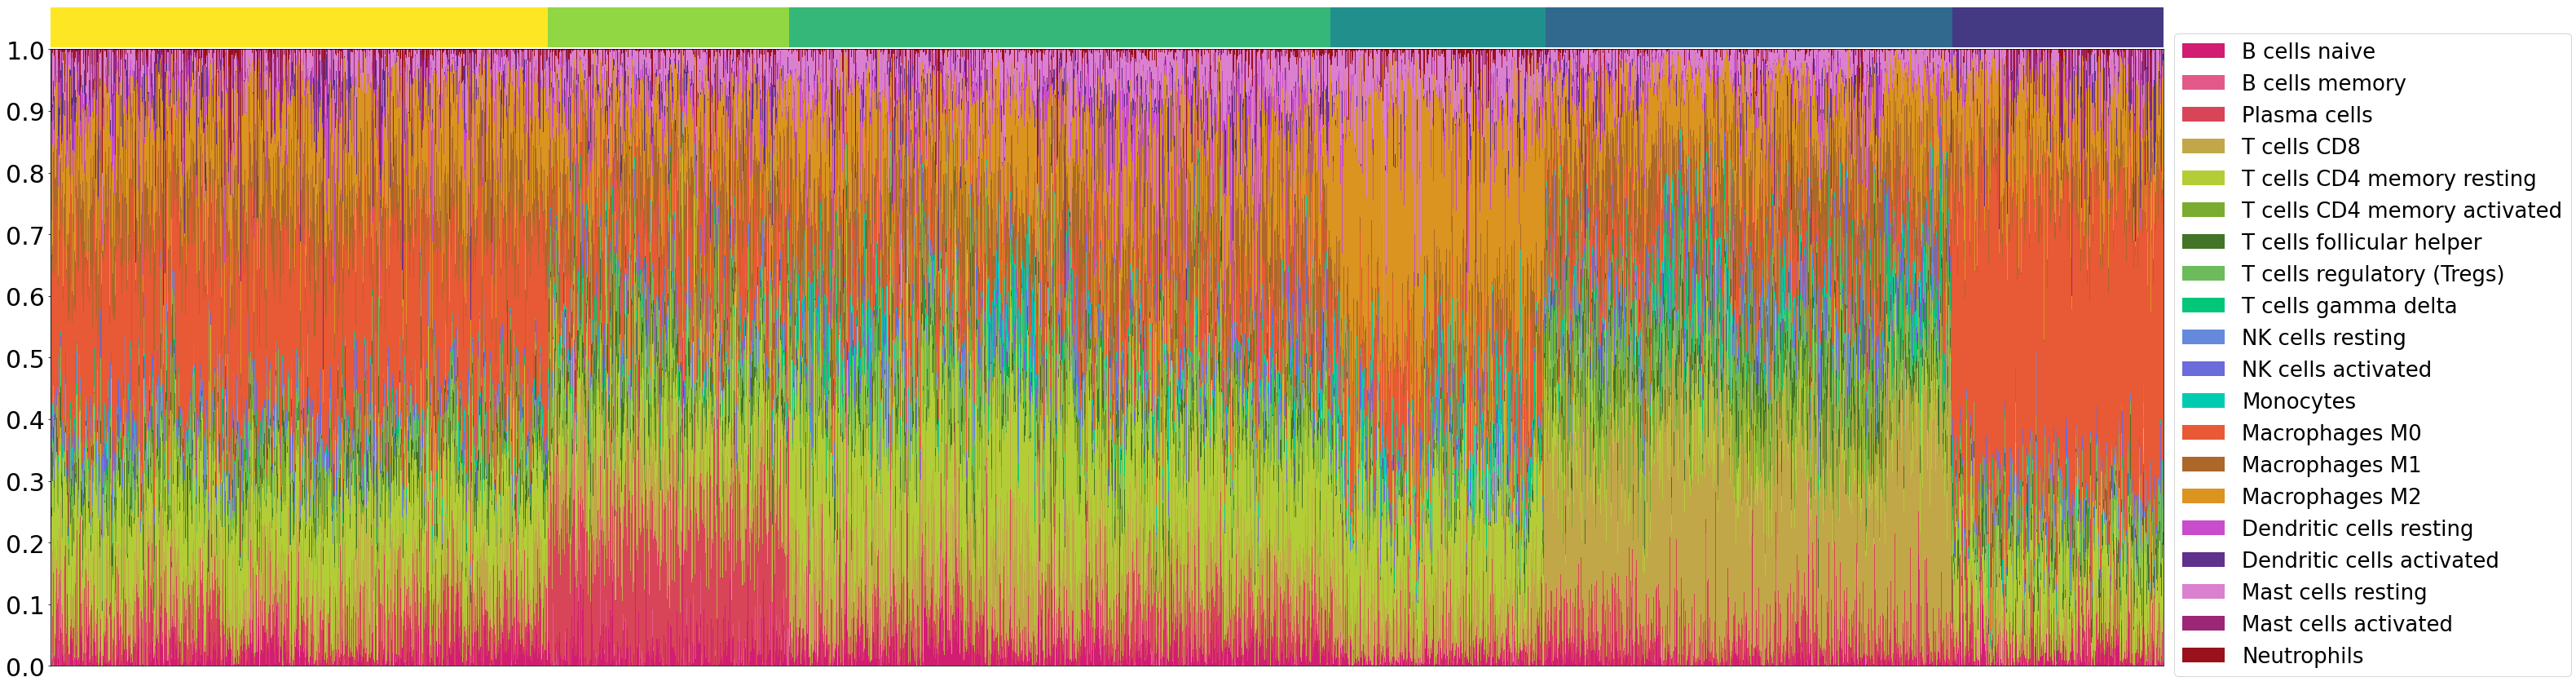

In [52]:
sorted_data,label,_ = LEUC.sort_data_by_label(data,None,None,direct_label=km6)
g6_stbar = LEUC.stack_barplot(sorted_data,label,cell_columns,cmap=color_ls)
rec_stbar_pdf.savefig()

In [53]:
rec_stbar_pdf.close()

# scatter distribution of cancer type

In [126]:
km_label.formal_cancer_type.unique()

array(['NSCLC', 'LIHC', 'CESC', 'SKCM', 'COREAD', 'BLAC', 'KIC', 'HNSC',
       'STAD', 'TNBC'], dtype=object)

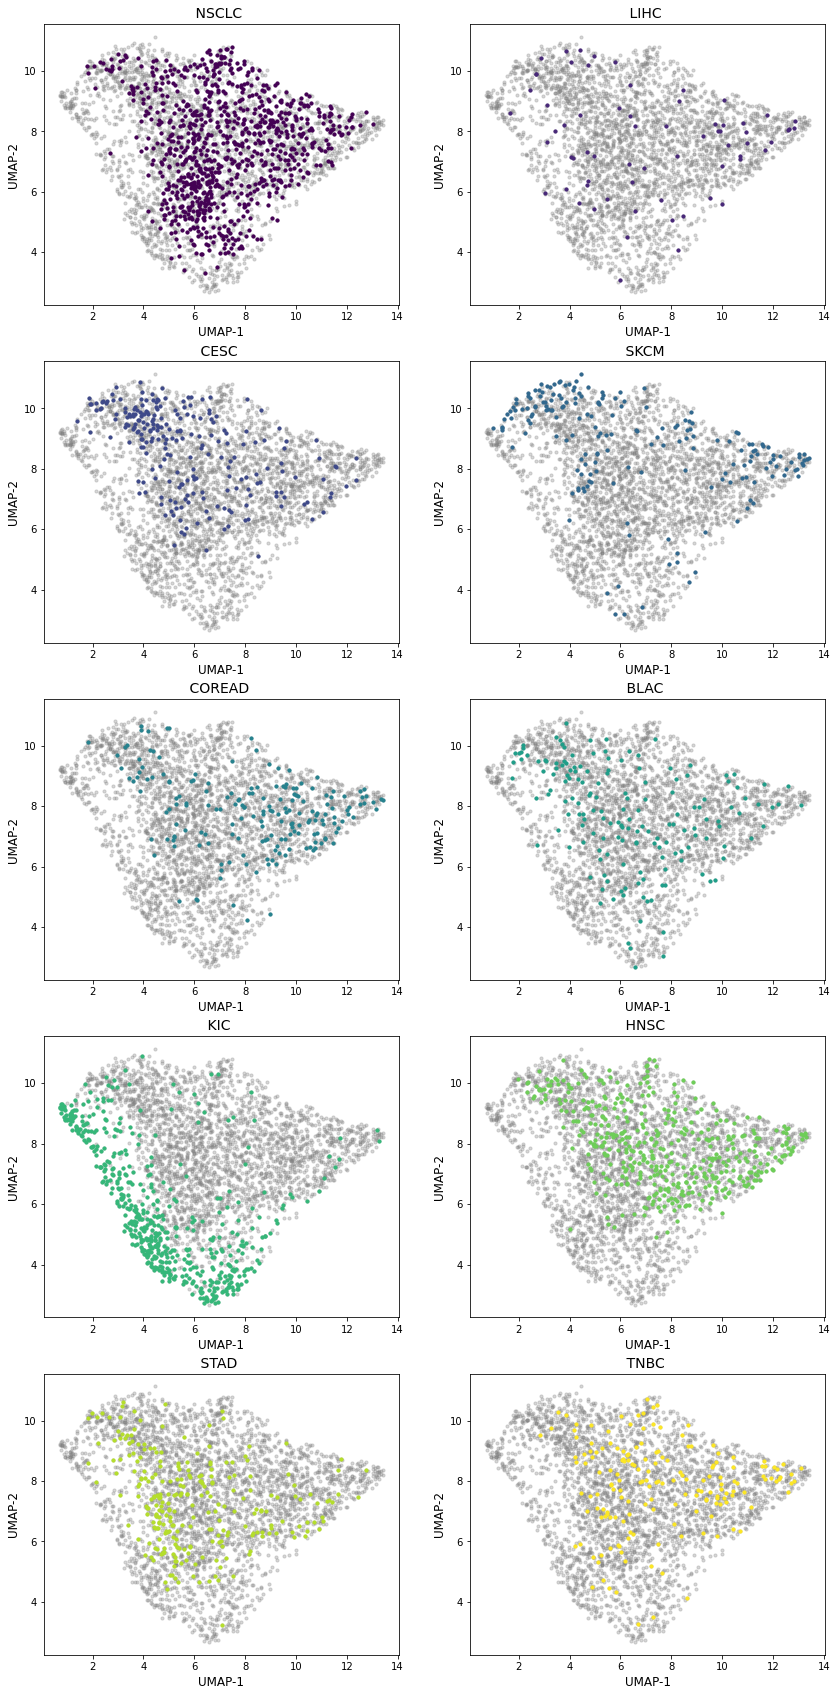

In [133]:
fig = plt.figure(figsize=(14,30))

for i,cancer_type in enumerate(all_type):
    
    point_of_type = n500_md036[km_label.formal_cancer_type == cancer_type]
    
    ax = fig.add_subplot(5,2,i+1)
    
    ax.set_xlabel('UMAP-1',fontsize=12)
    ax.set_ylabel('UMAP-2',fontsize=12)
    ax.set_title(' {}  '.format(cancer_type),fontsize=14)
    # scatter
    ax.scatter(n500_md036[:,0],n500_md036[:,1],s=10,color='gray',alpha=0.3);  # ALL
    ax.scatter(point_of_type[:,0],point_of_type[:,1],s=10,**{'color':cm.viridis(i/9)});   # specific cancer type 

In [134]:
cancer_type_dis = PdfPages('report/20210310_cancer_type_distribution.pdf')
cancer_type_dis.savefig(fig)
cancer_type_dis.close()